In [1]:
import torch
import torch.nn as nn
import torch.nn.functional as F

import numpy as np
import matplotlib.pylab as plt
from tqdm import trange
import os, requests, gzip, hashlib

/Users/James/opt/anaconda3/envs/dev/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


---

### DATA

In [2]:
def fetch(url):
    fp = os.path.join("/tmp", hashlib.md5(url.encode('utf-8')).hexdigest())
    if os.path.isfile(fp):
        with open(fp, "rb") as f:
            dat = f.read()
    else:
        with open(fp, "wb") as f:
            dat = requests.get(url).content
            f.write(dat)
    return np.frombuffer(gzip.decompress(dat), dtype=np.uint8).copy()

x_train = fetch("http://yann.lecun.com/exdb/mnist/train-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_train = fetch("http://yann.lecun.com/exdb/mnist/train-labels-idx1-ubyte.gz")[8:]
x_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-images-idx3-ubyte.gz")[0x10:].reshape((-1, 28, 28))
y_test = fetch("http://yann.lecun.com/exdb/mnist/t10k-labels-idx1-ubyte.gz")[8:]

---

### MODEL

In [3]:
class FeedForward(torch.nn.Module):
    def __init__(self):
        super(FeedForward, self).__init__()
        self.l1 = nn.Linear(28*28, 128, bias=False)
        self.l2 = nn.Linear(128, 10, bias=False)
        self.act = nn.LogSoftmax(dim=1)
    def forward(self, x):
        x = F.relu(self.l1(x))
        x = self.l2(x)
        x = self.act(x)
        return x

---

### TRAIN

In [4]:
model = FeedForward()
optimizer = torch.optim.Adam(model.parameters(), lr=0.001)

epochs = 1000
batch_size = 64
losses, accuracies = [], []

for i in (t:=trange(epochs)):
    sample = np.random.randint(0, x_train.shape[0], size=(batch_size))
    X = torch.tensor(x_train[sample].reshape((-1, 28*28))).float()
    Y = torch.tensor(y_train[sample]).long()

    model.zero_grad()
    logits = model(X)
    pred = torch.argmax(logits, dim=1)
    
    accuracy = (pred==Y).float().mean()
    loss = nn.CrossEntropyLoss()(logits, Y)
    loss = loss.mean()

    loss.backward()
    optimizer.step()

    losses.append(loss.item())
    accuracies.append(accuracy.item())
    t.set_description("Loss: %.2f Accuracy: %.2f" % (loss, accuracy))

Loss: 0.21 Accuracy: 0.92: 100%|██████████| 1000/1000 [00:02<00:00, 472.04it/s]


((0.0, 1000.0), None)

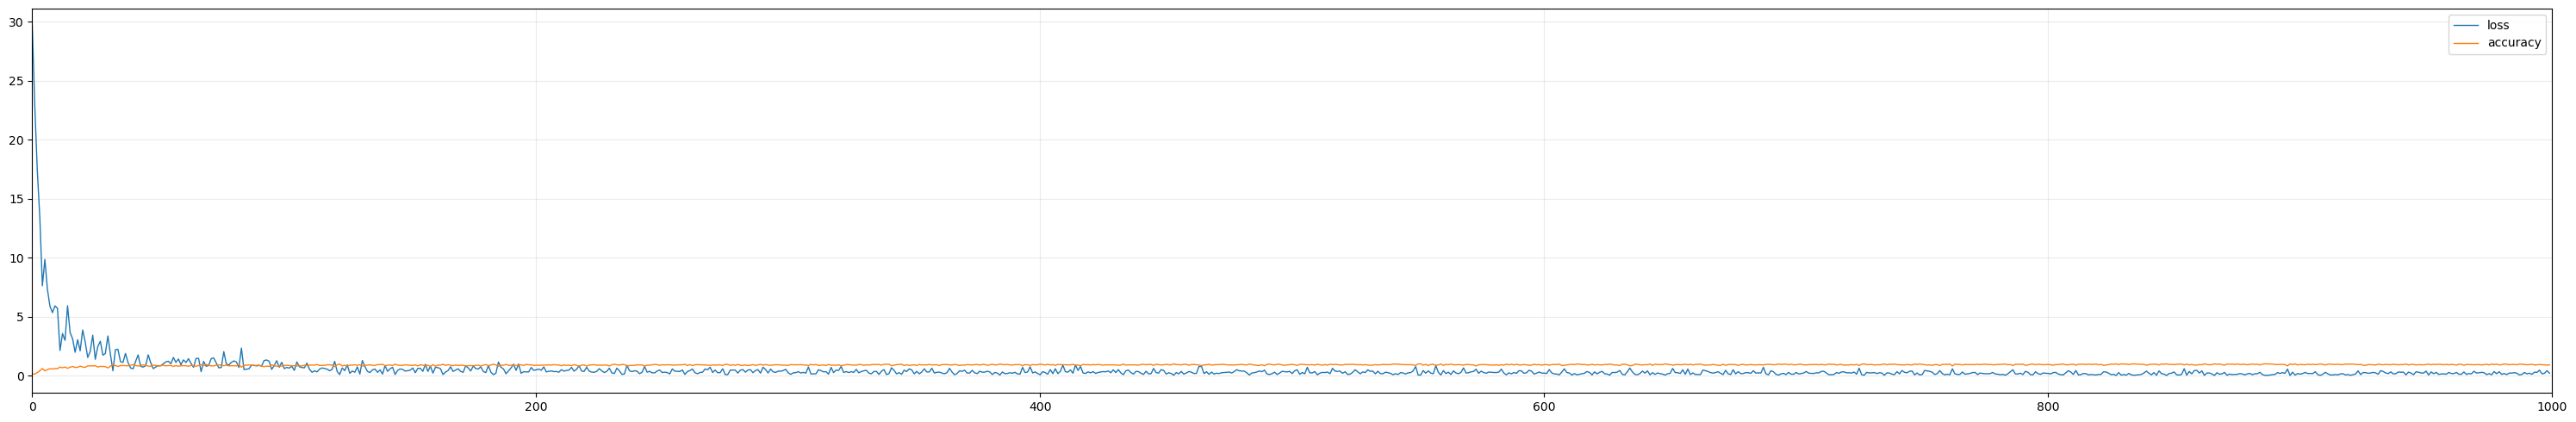

In [5]:
plt.figure(figsize=(30,5))
plt.plot(losses, label='loss', lw=1)
plt.plot(accuracies,label='accuracy', lw=1)
plt.grid(alpha=0.25), plt.legend()
plt.xlim([0,epochs]), plt.tight_layout()

---

### EXTRACT WEIGHTS

In [6]:
l1 = model.l1.weight.detach().numpy().T
l2 = model.l2.weight.detach().numpy().T

def np_forward(x):
    x = x.dot(l1)
    x = np.maximum(x, 0)
    x = x.dot(l2)  
    return x

def np_eval():
    preds_out = np_forward(x_test.reshape((-1, 28*28)))
    preds = np.argmax(preds_out, axis=1)
    return (y_test == preds).mean()

np_eval()

0.9411

4


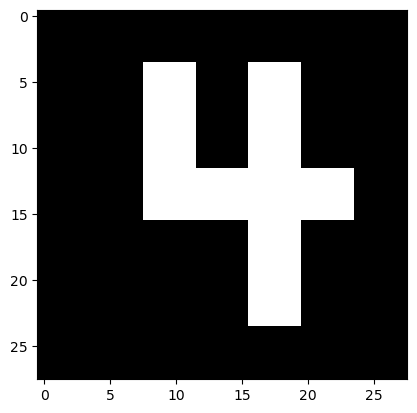

In [7]:
m = [[0,0,0,0,0,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,0,1,0,0],
     [0,0,1,1,1,1,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,1,0,0],
     [0,0,0,0,0,0,0]]

m = np.concatenate([np.concatenate([[x]*4 for x in y]*4) for y in m])
x = np_forward(m.reshape(1, -1))
x = np.argmax(x)

plt.imshow(m.reshape(28,28), 'gray')
print(x)

(128, 10)


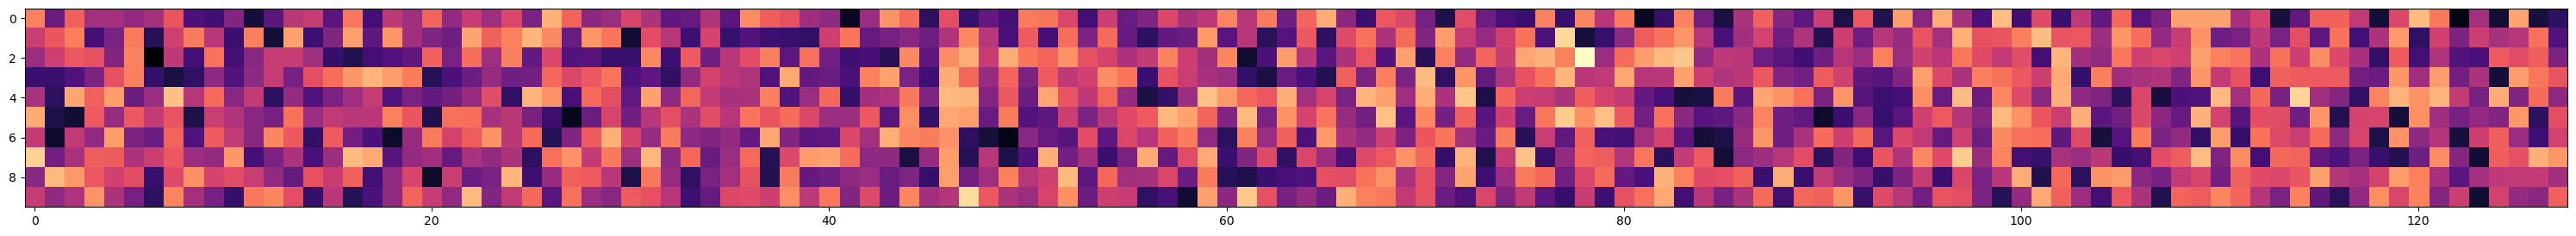

In [8]:
plt.figure(figsize=(30,5))
plt.imshow(l2.T, 'magma')
plt.tight_layout()
print(l2.shape)

In [9]:
# np.save('../data/weights/MNIST_l2.npy', l2)